In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [2]:
rerun = False
filename_end = "_2"
folder_name = "files/"

In [3]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]
M_0s[0] = 0.6
t2s[0] = 0.02
ws[0] = 2000
print(ws, t2s, M_0s)

spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


[2000.] [0.02] [0.6]
All frequencies are captured by the sampling rate.


In [4]:
sigma = 0.001

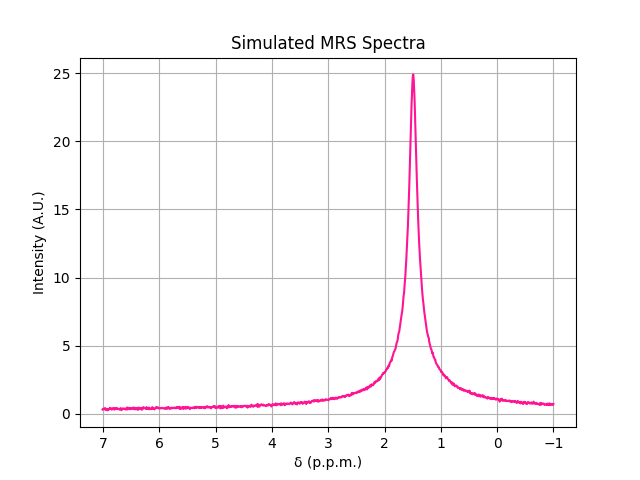

In [5]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig = pymri.corrupted_snr(sig, 0.0, sigma)
c_freqs, c_sig_fft = pymri.fourier_spectrum( c_sig, dt, B0 )

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [6]:
L = 0.4
noise_threshold = 1e-30

In [7]:
reconstructed_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True)

In [8]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2 = 1/alpha

In [9]:
# i = np.arange(0, omega.size, 1)

# plt.subplot(221)
# plt.plot(i, s0)
# plt.title("S0")
# plt.grid()

# plt.subplot(222)
# plt.plot(i, phi)
# plt.title("Phi")
# plt.grid()

# plt.subplot(223)
# plt.plot(i, omega)
# plt.title("Omega")
# plt.grid()

# plt.subplot(224)
# plt.plot(i, t2)
# plt.title("t2")
# plt.grid()

# plt.show()

[(-500.0, 500.0)]

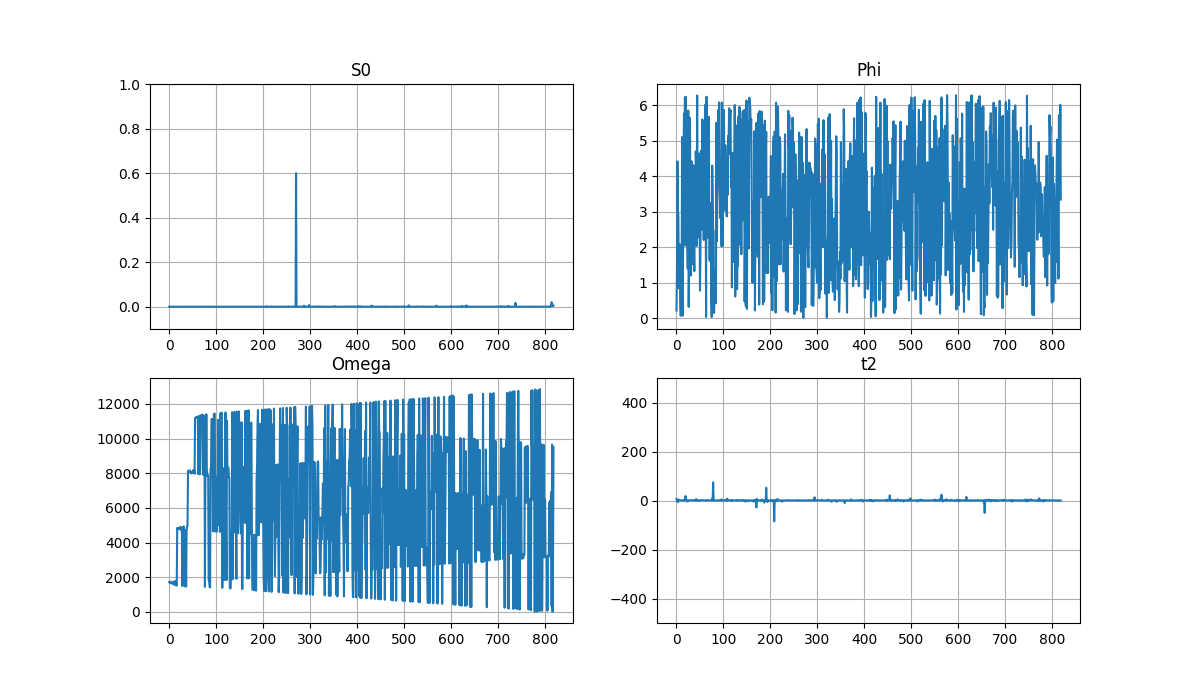

In [10]:
i = np.arange(0, omega.size, 1)

fig, ax = plt.subplots(2, 2, figsize=(12, 7))

# plt.ioff()
# plt.ion()

ax00 = ax[0, 0].plot(i, s0)[0]
ax[0, 0].set_title("S0")
ax[0, 0].grid()
# ax[0, 0].legend()
ax[0, 0].set(ylim=[-0.1, 1.0])

ax01 = ax[0, 1].plot(i, phi)[0]
ax[0, 1].set_title("Phi")
ax[0, 1].grid()
# ax[0, 1].legend()

ax10 = ax[1, 0].plot(i, omega)[0]
ax[1, 0].set_title("Omega")
ax[1, 0].grid()
# ax[1, 0].legend()

ax11 = ax[1, 1].plot(i, t2)[0]
ax[1, 1].set_title("t2")
ax[1, 1].grid()
# ax[1, 1].legend()
ax[1, 1].set(ylim=[-500, 500])

In [11]:
sigma = np.arange(0.0, 0.04, 0.001)

s0_arr = np.zeros((sigma.size, s0.size))
phi_arr = np.zeros((sigma.size, s0.size))
omega_arr = np.zeros((sigma.size, s0.size))
t2_arr = np.zeros((sigma.size, s0.size))

In [12]:
if rerun == True:
    for i in range(sigma.size):
        c_sig = pymri.corrupted_snr(sig, 0.0, sigma[i])

        r_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
        s0_arr[i, :], phi_arr[i, :], omega_arr[i, :], t2_arr[i, :] = pymri.calculate_variables_from_z_and_r(z, r, dt)
        t2_arr[i, :] = 1/t2_arr[i, :]

In [13]:
subfolder_name = "single_peak/"
if rerun == True:
    file = open(folder_name + subfolder_name + "s0_arr" + filename_end + ".csv", "w")
    file.write(",".join(str(x) for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in s0_arr[i, :]) + "\n")
    file.close()


    file = open(folder_name + subfolder_name + "phi_arr" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in phi_arr[i, :]) + "\n")
    file.close()


    file = open(folder_name + subfolder_name + "omega_arr" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in omega_arr[i, :]) + "\n")
    file.close()


    file = open(folder_name + subfolder_name + "t2_arr" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in range(omega.size)) + "\n")
    for i in range(sigma.size):
        file.write(",".join(str(x) for x in t2_arr[i, :]) + "\n")
    file.close()
    

In [14]:
# If simulation is lost
if(rerun == False):
    file_in = pd.read_csv(folder_name + subfolder_name + "s0_arr" + filename_end + ".csv")
    s0_arr = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "phi_arr" + filename_end + ".csv")
    phi_arr = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "omega_arr" + filename_end + ".csv")
    omega_arr = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "t2_arr" + filename_end + ".csv")
    t2_arr = file_in.values


In [15]:
from ipywidgets import *
from matplotlib.widgets import Slider
import matplotlib.animation as animation

In [16]:
ax_slider = plt.axes([0.25, 0.0, 0.65, 0.03], facecolor="lightgoldenrodyellow"  )
slider = Slider(ax_slider, "sigma", sigma[0], sigma[-1], valinit=sigma[0], valstep= (sigma[-1] - sigma[0])/sigma.size)# 

In [17]:
# y_off = 0.15

# def update(frame):
#     ax00.set(ylim = [ymin - y_off*ymin, ymax + y_off*ymax])
#     ax00.set_ydata(s0_arr[slider.val, :])
#     ymin, ymax = np.min(s0_arr[slider.val, :]), np.max(s0_arr[slider.val, :])

#     ax01.set(ylim = [ymin - y_off*ymin, ymax + y_off*ymax])
#     ax01.set_ydata(phi_arr[slider.val, :])
#     ymin, ymax = np.min(phi_arr[slider.val, :]), np.max(phi_arr[slider.val, :])

#     ax10.set(ylim = [ymin - y_off*ymin, ymax + y_off*ymax])
#     ax10.set_ydata(omega_arr[slider.val, :])
#     ymin, ymax = np.min(omega_arr[slider.val, :]), np.max(omega_arr[slider.val, :])

#     ax11.set(ylim = [ymin - y_off*ymin, ymax + y_off*ymax])
#     ax11.set_ydata(t2_arr[slider.val, :])
#     ymin, ymax = np.min(t2_arr[slider.val, :]), np.max(t2_arr[slider.val, :])

#     fig.canvas.draw_idle()

# slider.on_changed(update)

# plt.show()

In [18]:
def quadratic(start : float, stop : float, n_frames : int):
    t = np.linspace(start, stop, n_frames)
    v = (stop - start)/n_frames
    f = t**2 + t 

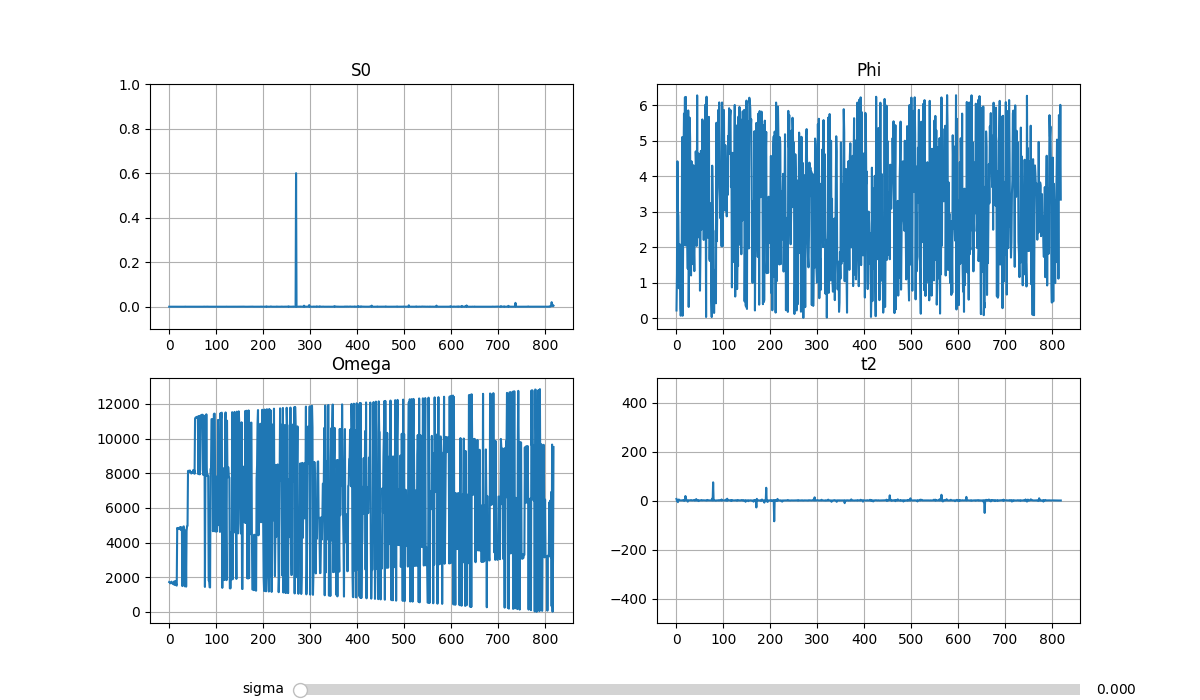

In [19]:
def update(frame):
    step = int(slider.val*sigma.size/(sigma[-1] - sigma[0]))
    sort_arr = np.argsort(s0_arr[step, :])
    ax00.set_ydata(s0_arr[step, :][sort_arr])
    ax01.set_ydata(phi_arr[step, :][sort_arr])
    ax10.set_ydata(omega_arr[step, :][sort_arr])
    ax11.set_ydata(t2_arr[step, :][sort_arr])
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()

[(-500.0, 500.0)]

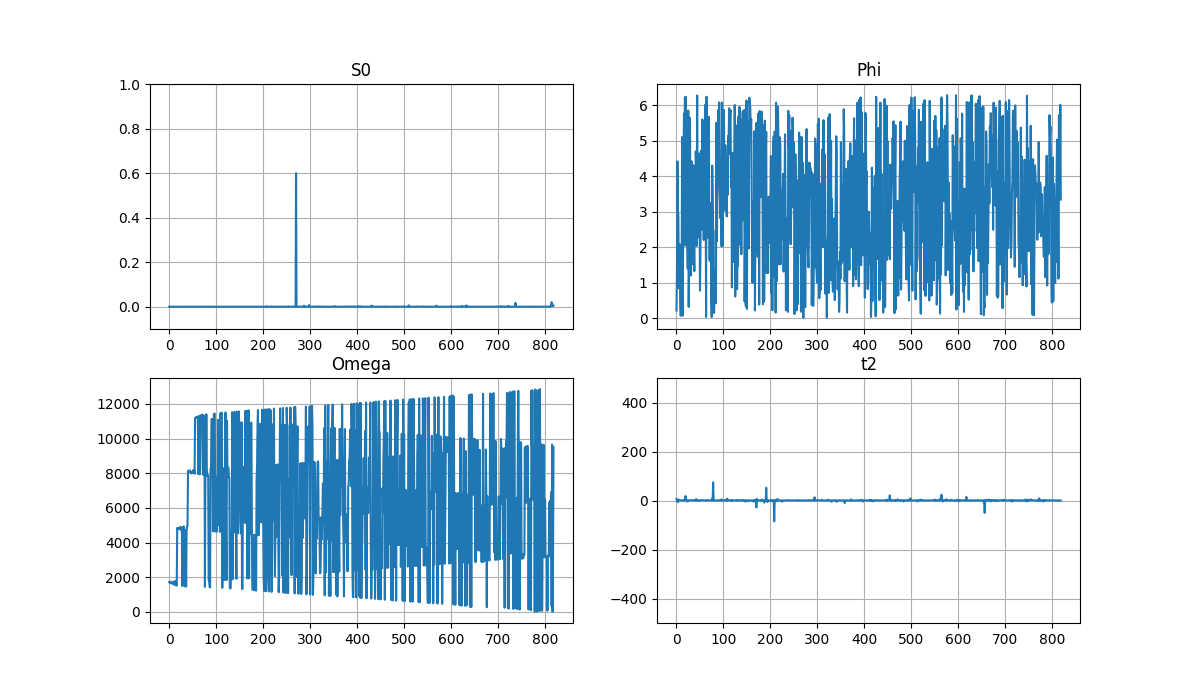

In [20]:
fig_2, ax_2 = plt.subplots(2, 2, figsize=(12, 7))
i = np.arange(0, s0.size, 1)

# plt.ioff()
# plt.ion()

ax00_2 = ax_2[0, 0].plot(i, s0, label = "")[0]
ax_2[0, 0].set_title("S0")
ax_2[0, 0].grid()
ax_2[0, 0].set(ylim=[-0.1, 1.0])

ax01_2 = ax_2[0, 1].plot(i, phi, label = "")[0]
ax_2[0, 1].set_title("Phi")
ax_2[0, 1].grid()

ax10_2 = ax_2[1, 0].plot(i, omega, label = "")[0]
ax_2[1, 0].set_title("Omega")
ax_2[1, 0].grid()

ax11_2 = ax_2[1, 1].plot(i, t2, label = "")[0]
ax_2[1, 1].set_title("t2")
ax_2[1, 1].grid()
ax_2[1, 1].set(ylim=[-500, 500])

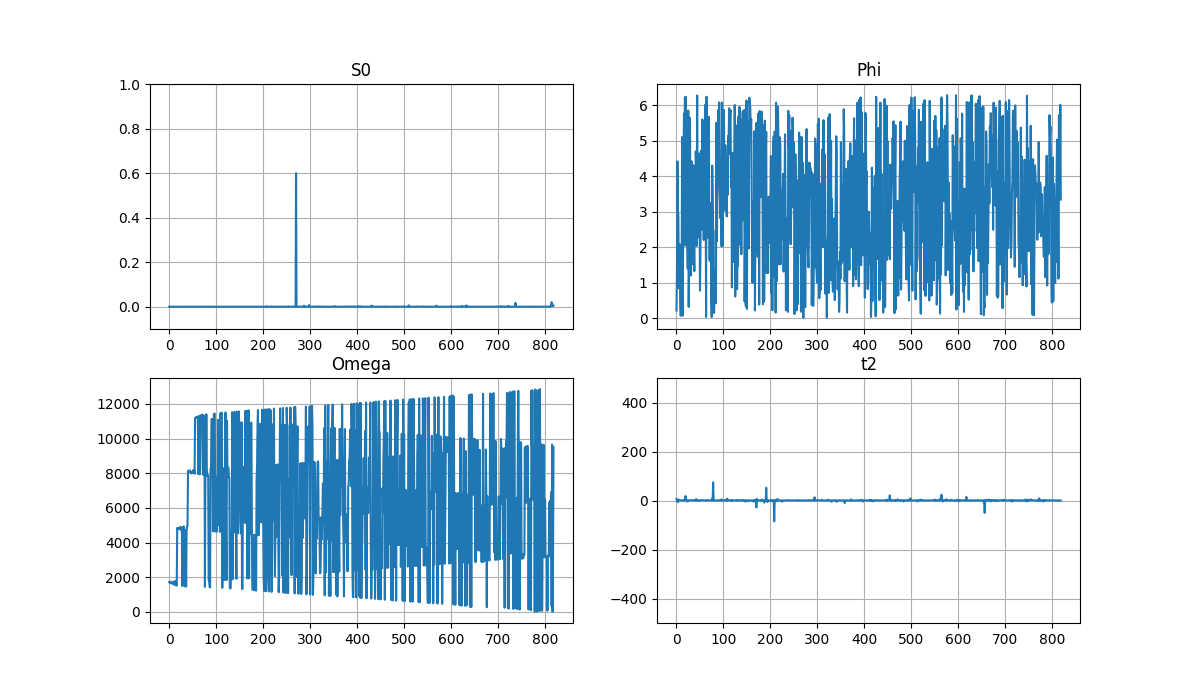

In [21]:
def update_anim(frame):
    # step = int(slider.val*sigma.size/(sigma[-1] - sigma[0]))
    ax00_2.set_ydata(np.sort(s0_arr[frame, :]))
    ax01_2.set_ydata(np.sort(phi_arr[frame, :]))
    ax10_2.set_ydata(np.sort(omega_arr[frame, :]))
    ax11_2.set_ydata(np.sort(t2_arr[frame, :]))
    # fig.canvas.draw_idle()

ani = animation.FuncAnimation(fig_2, update_anim, frames=sigma.size, interval = 30)

fig_2.show()